In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBClassifier


from sklearn.metrics import confusion_matrix ,accuracy_score

import warnings
warnings.filterwarnings('ignore')
import re

In [2]:
# read the data set
df = pd.read_csv('laptop_price.csv')

In [3]:
df.head(2)

,product_name,product_brand,product_model,chipset,ram,graphics,webcams,connectivities,batteries,adapters,operating_system,dimentions,weight,product_price
0,HP PAVILION 15-EG2117TU 15.6 INCH FULL HD IPS ...,HP,PAVILION 15-EG2117TU,Intel Core i7-1260P\nup to 4.7 GHz \nIntel Tur...,8 GB DDR4-3200 MHz RAM (2 x 4 GB),Integrated\nIntel Iris X Graphics,HP Wide Vision 720p HD camera with temporal no...,Wi-Fi- MediaTek Wi-Fi 6 MT7921 (2x2)\nBluetoot...,"Battery type- 3-cell, 41 Wh Li-ion \nBattery l...",65 W Smart AC power adapter,Windows 11 Home,36.02 x 23.4 x 1.79 cm,1.74 kg,"112,500৳"
1,ASUS TUF GAMING A15 FA507RM 15.6 INCH FHD 144H...,Asus,TUF GAMING A15 FA507RM,AMD Ryzen 7 6800H Mobile Processor (8-core/16-...,"16GB DDR5-4800MHZ SO-DIMM, \nMax Capacity:32GB...",NVIDIA® GeForce RTX™ 3060 6GB GDDR6 Laptop GPU...,720P HD camera,Wi-Fi 6(802.11ax) (Dual band) 2*2,"90WHrs, 4S1P, 4-cell Li-ion\n","ø6.0, 240W AC Adapter, Output: 20V DC, 12A, 24...",Windows 11 Home\n,"35.4 x 25.1 x 2.24 ~ 2.49 cm \n(13.94"" x 9.88""...",2.20 Kg (4.85 lbs)\n,"181,900৳"


## exploratory data analysis (EDA)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   product_name      1100 non-null   object
 1   product_brand     1100 non-null   object
 2   product_model     1100 non-null   object
 3   chipset           1100 non-null   object
 4   ram               1100 non-null   object
 5   graphics          1100 non-null   object
 6   webcams           1100 non-null   object
 7   connectivities    1100 non-null   object
 8   batteries         1100 non-null   object
 9   adapters          1100 non-null   object
 10  operating_system  1099 non-null   object
 11  dimentions        1100 non-null   object
 12  weight            1100 non-null   object
 13  product_price     1100 non-null   object
dtypes: object(14)
memory usage: 120.4+ KB


In [5]:
# extract ram form the df and restore this in ram column

df['ram'] = df['ram'].apply(lambda x : re.findall(r'\b\d+\s*(?:GB|MB|TB)\b', x))
df['ram'] = df['ram'].str.get(0)
df['ram'] = df['ram'].apply(lambda x: re.findall(r'\d+',str(x))).str.get(0)

In [6]:
df['graphics'].head()

0                    Integrated\nIntel Iris X Graphics
1    NVIDIA® GeForce RTX™ 3060 6GB GDDR6 Laptop GPU...
2    Graphic: NVIDIA GeForce RTX 3060 Laptop GPU \n...
3    NVIDIA GeForce RTX 3050 Ti Laptop GPU, 1745MHz...
4                 NVIDIA® GeForce RTX™ 3060 Laptop GPU
Name: graphics, dtype: object

In [7]:
# extract graphics form the df and restore this in graphics column

def grap(text):
    # Categorizes graphics into specific groups based on their names.
    
    if 'Intel' in text:
        return 'intel'
    elif 'AMD' in text:
        return 'amd'
    elif 'NVIDIA' in text:
        return 'nvidia'
    else:
        return 'others'
df['graphics'] = df['graphics'].apply(grap)
df['graphics'].value_counts()

graphics
intel     450
nvidia    270
others    247
amd       133
Name: count, dtype: int64

In [9]:
# extract chip or prcessor from the df and store this in chipset column

df['chipset'] = df['chipset'].apply(lambda x : x.lower())

def chip(text):
    # Categorizes chipsets into specific groups based on their names.

    if 'intel' in text and 'i7' in text:
        return 'intel i7'  
    
    elif 'intel' in text and 'i3' in text:
        return 'intel i3'  
      
    elif 'intel' in text and 'i5' in text:
        return 'intel i5' 
    
    elif 'amd' in text:
        return 'amd'  
    
    else:
        return 'others' 
    
df['chipset'] = df['chipset'].apply(chip) 
   
df['chipset'].value_counts()

chipset
others      273
intel i5    267
amd         219
intel i7    212
intel i3    129
Name: count, dtype: int64

In [10]:
# extract os from the data and restore this in operating system column

df['operating_system'] = df['operating_system'].apply(lambda x : str(x).lower())

def os(text):
# Categorizes operating system into specific groups based on their names.

    if 'win' in text:
        return 'windows'
    
    elif 'macos' in text:
        return 'macos'
    
    elif 'linax' in text or 'dos' in text:
        return 'linax/dos'
    
    else:
        return 'others'


df['operating_system']= df['operating_system'].apply(os)

df['operating_system'].value_counts()

operating_system
windows      882
linax/dos    125
macos         53
others        40
Name: count, dtype: int64

In [11]:
# extract batteries from the data and restore this in batteries column

df['batteries'] = df['batteries'].apply(lambda x : re.findall(r'\b\d+\s*(?:wh|Wh|whrs)\b', str(x).lower()))
df['batteries'] = df['batteries'].apply(lambda x: re.findall(r'\d+', str(x))).str.get(0)

In [12]:
# extract adpter from the data and restore this in adapter column

df['adapters'] = df['adapters'].apply(lambda x : re.findall( r'\b\d+\s*(?:w|W)\b', str(x))).str.get(0)
df['adapters'] = df['adapters'].apply(lambda x : re.findall(r'\d+', str(x))).str.get(0)

In [13]:
# extract product model from the data and restore this in product model column

df['product_model'] = df['product_model'].apply(lambda x : x.lower())

def model(text):
    if 'ideapad' in text:
        return 'ideapad'
    elif 'vivobook' in text:
        return 'vivobook'
    elif 'macbook' in text:
        return 'macbook'
    elif 'inspiron' in text:
        return 'inspiron'
    elif 'tuf' in text:
        return 'tuf'
    elif 'aspire' in text:
        return 'aspire'
    elif 'zenbook' in text:
        return 'zenbook'
    elif 'legion' in text:
        return 'legion'
    elif 'rog' in text:
        return 'rog'
    elif 'expertbook' in text:
        return 'expertbook'
    elif 'modern' in text:
        return 'modern'
    elif 'pavilion' in text:
        return 'pavilion'
    elif 'probook' in text:
        return 'probook'
    else:
        return 'others'

df['product_model'] = df['product_model'].apply(model)
 

In [14]:
# extract product brand from the data and restore this in product brand column

brand_mapping = {
    'asus': 'asus',
    'lenovo': 'lenovo',
    'hp': 'hp',
    'msi': 'msi',
    'acer': 'acer',
    'dell': 'dell',
    'apple': 'apple',
    'avita': 'avita',
    'gigabyte': 'gigabyte'
}

def map_brand(text):
    text = str(text).lower()
    for brand, category in brand_mapping.items():
        if brand in text:
            return category
    return 'other brand'  # Default value for other brands

df['product_brand'] = df['product_brand'].map(map_brand)
df['product_brand'].value_counts()


product_brand
asus           338
lenovo         260
hp             115
msi             89
acer            79
dell            74
apple           53
other brand     51
avita           24
gigabyte        17
Name: count, dtype: int64

In [15]:
# extract weight from the df and restore this in weight column

df['weight'] = df['weight'].apply(lambda x : re.findall(r'\d+.\d+', str(x))).str.get(0)
df['weight'] = df['weight'].apply(lambda x : str(x).replace(',' , ''))
df['weight'].head(3)

0    1.74
1    2.20
2    2.30
Name: weight, dtype: object

In [16]:
# extract product price  from the df and restore this in product price column

df['product_price'] = df['product_price'].str.replace(',', '')
df['product_price'] = df['product_price'].apply(lambda x : re.findall(r'\d+', str(x))).str.get(0)
df['product_price'].head(3)

0    112500
1    181900
2    218000
Name: product_price, dtype: object

In [17]:
# extract ssd from the df and restore this in ssd column

df['ssd'] = df['product_name'].apply(lambda x : re.findall(r'\b(\d+s*(?:gb|tb)\s*(?:hdd|ssd))\b', str(x).lower())).str.get(0)
df['ssd'] = df['ssd'].apply(lambda x : re.findall(r'\d+', str(x))).str.get(0)
df['ssd'].value_counts().head(3)

ssd
512    634
1      232
256     92
Name: count, dtype: int64

In [18]:
# extract touch from the df and restore this in touch column

df['touch'] = df['product_name'].apply(lambda x : 'yes' if 'touch' in str(x).lower() else 'no' )
df['touch'].head()

0    no
1    no
2    no
3    no
4    no
Name: touch, dtype: object

In [19]:
def disp(text):
    text = str(text).lower()
    if 'fhd' in text or 'hd' in text:
        return 'fhd'
    elif 'ips' in text:
        return 'ips'
    elif 'led' in text:
        return 'led'
    else:
        return 'normal'

df['display'] = df['product_name'].apply(disp)


In [20]:
# drops all the unnecessary columns
df.drop(columns= ['product_name', 'dimentions','connectivities', 'webcams'], axis=1, inplace=True)

In [21]:
# convert all in upper case 
col_list = ['product_brand', 'product_model', 'chipset', 'graphics', 'operating_system', 'touch', 'display']
for col in col_list:
    df[col] = df[col].apply(lambda x: str(x).upper())


In [22]:
df.head(10)

,product_brand,product_model,chipset,ram,graphics,batteries,adapters,operating_system,weight,product_price,ssd,touch,display
0,HP,PAVILION,INTEL I7,8,INTEL,41,65,WINDOWS,1.74,112500,512,NO,FHD
1,ASUS,TUF,AMD,16,NVIDIA,90,240,WINDOWS,2.20,181900,512,NO,FHD
2,ASUS,ROG,AMD,16,NVIDIA,90,240,WINDOWS,2.30,218000,512,NO,FHD
3,ASUS,TUF,AMD,16,NVIDIA,90,180,WINDOWS,2.20,153900,512,NO,FHD
4,ASUS,TUF,AMD,16,NVIDIA,90,200,WINDOWS,2.60,176000,512,NO,FHD
5,ASUS,ROG,AMD,16,NVIDIA,90,100,WINDOWS,1.90,265000,1,NO,FHD
6,HP,PROBOOK,INTEL I5,8,INTEL,51,NaN,WINDOWS,1.38,90000,512,NO,FHD
7,LENOVO,IDEAPAD,AMD,8,AMD,45,65,LINAX/DOS,1.5,66000,512,NO,FHD
8,LENOVO,IDEAPAD,INTEL I3,4,INTEL,35,65,WINDOWS,1.85,47500,256,NO,FHD
9,LENOVO,IDEAPAD,INTEL I5,8,NVIDIA,38,65,WINDOWS,1.6,78500,512,NO,FHD


In [23]:
# filter all column on basis of null product price column
filtered_df = df[pd.notna(df['product_price'])]
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 665 entries, 0 to 664
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   product_brand     665 non-null    object
 1   product_model     665 non-null    object
 2   chipset           665 non-null    object
 3   ram               533 non-null    object
 4   graphics          665 non-null    object
 5   batteries         442 non-null    object
 6   adapters          392 non-null    object
 7   operating_system  665 non-null    object
 8   weight            665 non-null    object
 9   product_price     665 non-null    object
 10  ssd               567 non-null    object
 11  touch             665 non-null    object
 12  display           665 non-null    object
dtypes: object(13)
memory usage: 72.7+ KB


In [24]:
# encoded all the categorical column 

col_list = ['product_brand', 'product_model', 'chipset', 'graphics', 'operating_system', 'touch', 'display']
lvl_encoder = LabelEncoder()
for col in col_list:
    filtered_df[col] = lvl_encoder.fit_transform(filtered_df[[col]])



In [25]:
# check the filtered and encoded df
filtered_df.head()

,product_brand,product_model,chipset,ram,graphics,batteries,adapters,operating_system,weight,product_price,ssd,touch,display
0,6,8,3,8,1,41,65,3,1.74,112500,512,0,0
1,2,11,0,16,2,90,240,3,2.20,181900,512,0,0
2,2,10,0,16,2,90,240,3,2.30,218000,512,0,0
3,2,11,0,16,2,90,180,3,2.20,153900,512,0,0
4,2,11,0,16,2,90,200,3,2.60,176000,512,0,0


In [26]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 665 entries, 0 to 664
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   product_brand     665 non-null    int32 
 1   product_model     665 non-null    int32 
 2   chipset           665 non-null    int32 
 3   ram               533 non-null    object
 4   graphics          665 non-null    int32 
 5   batteries         442 non-null    object
 6   adapters          392 non-null    object
 7   operating_system  665 non-null    int32 
 8   weight            665 non-null    object
 9   product_price     665 non-null    object
 10  ssd               567 non-null    object
 11  touch             665 non-null    int32 
 12  display           665 non-null    int32 
dtypes: int32(7), object(6)
memory usage: 54.6+ KB


In [27]:
# impute the null value with knn imputer
kn_imputer = KNNImputer(n_neighbors=5)
kn_trns = kn_imputer.fit_transform(filtered_df)
kndf = pd.DataFrame(kn_trns, columns=filtered_df.columns)
kndf.head()

,product_brand,product_model,chipset,ram,graphics,batteries,adapters,operating_system,weight,product_price,ssd,touch,display
0,6.0,8.0,3.0,8.0,1.0,41.0,65.0,3.0,1.74,112500.0,512.0,0.0,0.0
1,2.0,11.0,0.0,16.0,2.0,90.0,240.0,3.0,2.20,181900.0,512.0,0.0,0.0
2,2.0,10.0,0.0,16.0,2.0,90.0,240.0,3.0,2.30,218000.0,512.0,0.0,0.0
3,2.0,11.0,0.0,16.0,2.0,90.0,180.0,3.0,2.20,153900.0,512.0,0.0,0.0
4,2.0,11.0,0.0,16.0,2.0,90.0,200.0,3.0,2.60,176000.0,512.0,0.0,0.0


In [28]:
# converting TB to GB
kndf['ssd'] = kndf['ssd'].apply(lambda x : x * 1000 if x <= 4 else x)   


## visualized the categorical column

In [60]:
# Define a custom style
custom_style = {
    "figure.facecolor": "#222831",  # Background color
    "axes.facecolor": "#31363F",     # Axes background color
    "axes.edgecolor": "white",       # Axes edge color
    "axes.labelcolor": "white",      # Axes label color
    "text.color": "white",           # Text color
    "xtick.color": "white",          # X-axis tick color
    "ytick.color": "white",          # Y-axis tick color
}

plt.style.use([custom_style])  # Apply both styles

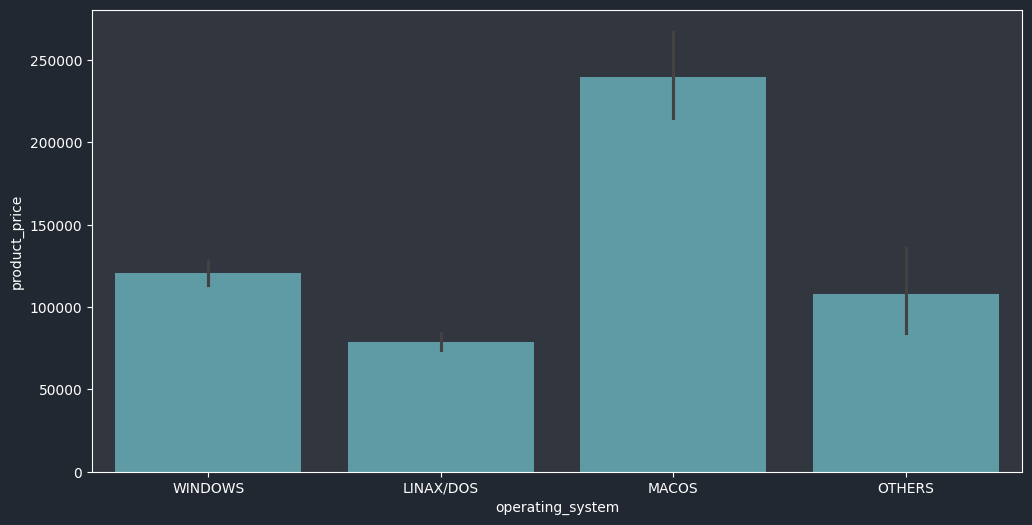

In [66]:
plt.figure(figsize=(12,6))
# bar plot respect to operating system

sns.barplot(x=df['operating_system'], y =kndf['product_price'], color= '#54A4AF')
plt.xticks(rotation='horizontal')
plt.show()

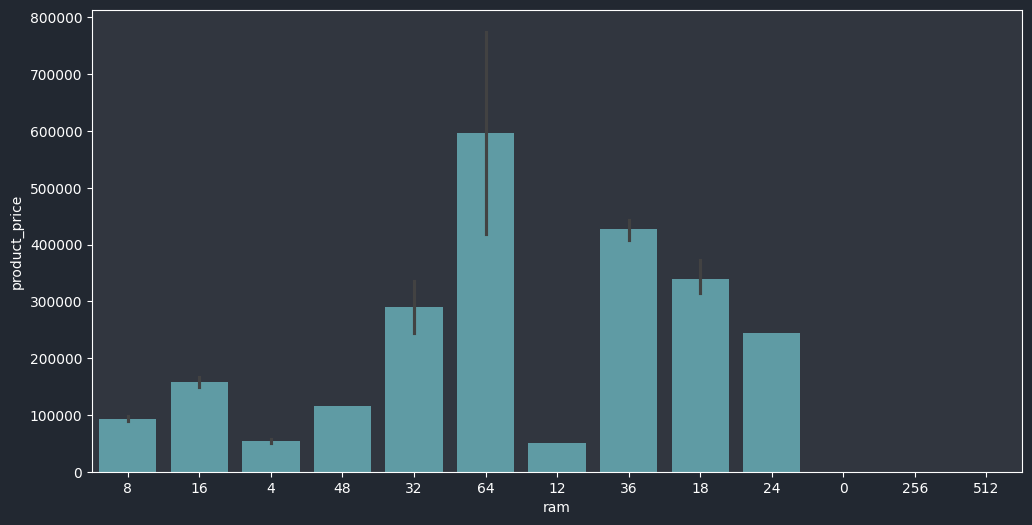

In [67]:
plt.figure(figsize=(12,6))
# bar plot respect to ram

sns.barplot(x=df['ram'], y =kndf['product_price'], color= '#54A4AF')
plt.xticks(rotation='horizontal')
plt.show()

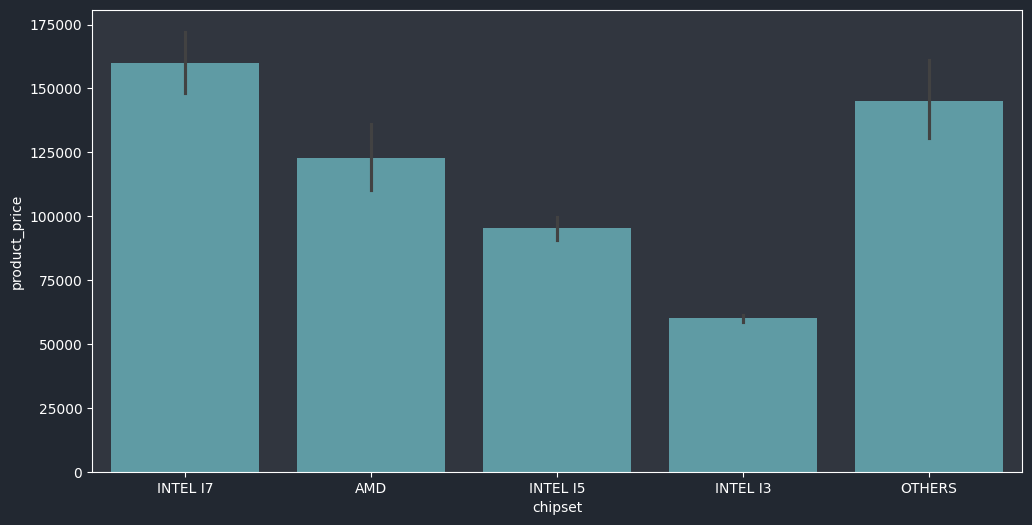

In [68]:
plt.figure(figsize=(12,6))
# bar plot respect to chipset

sns.barplot(x=df['chipset'], y =kndf['product_price'], color= '#54A4AF')
plt.xticks(rotation='horizontal')
plt.show()

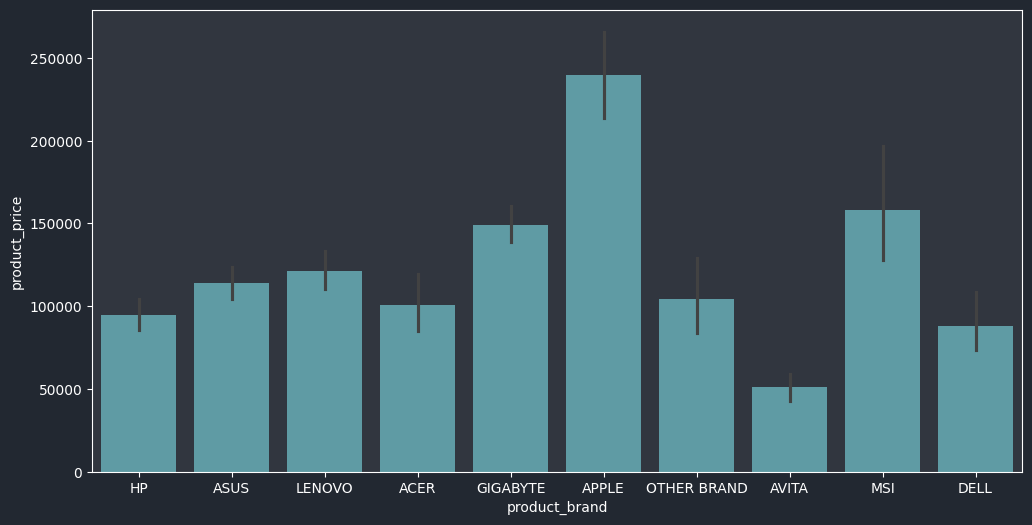

In [69]:
plt.figure(figsize=(12,6))
# bar plot respect to brand

sns.barplot(x=df['product_brand'], y =kndf['product_price'], color= '#54A4AF')
plt.xticks(rotation='horizontal')
plt.show()

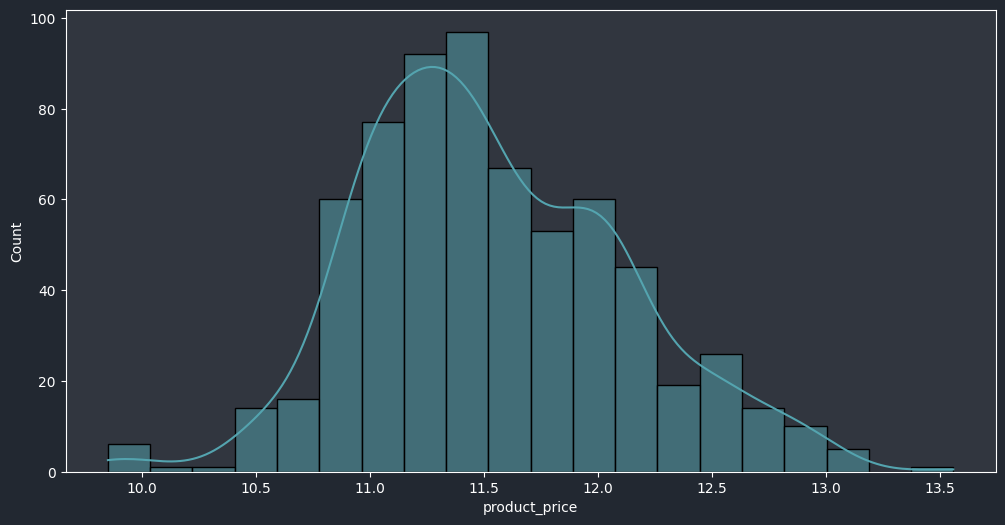

In [70]:
plt.figure(figsize=(12,6))
# histogram plot with kde

sns.histplot(np.log(kndf['product_price']), kde=True , color= '#54A4AF')
plt.show()


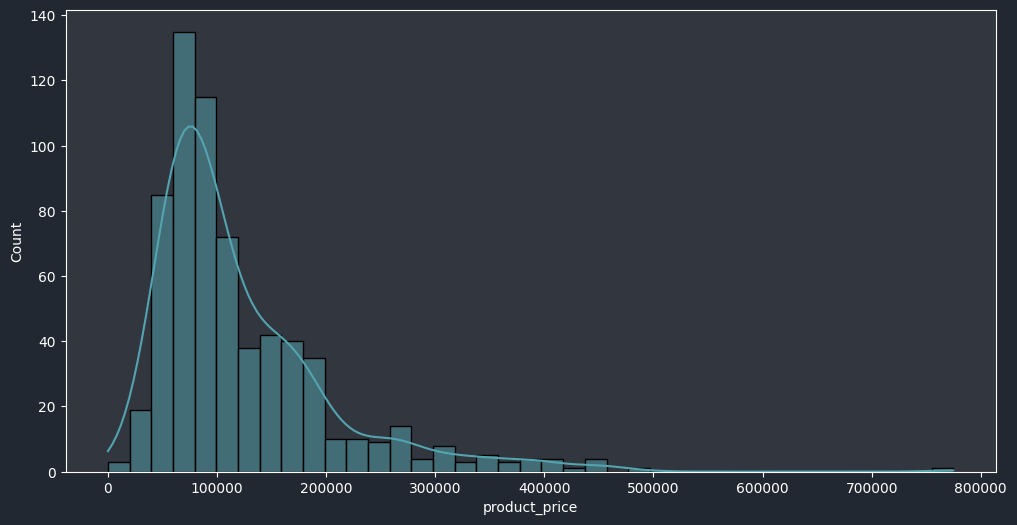

In [71]:
plt.figure(figsize=(12,6))
# histogram plot with kde

sns.histplot(kndf['product_price'], kde= True, color= '#54A4AF')
plt.show()

<Axes: >

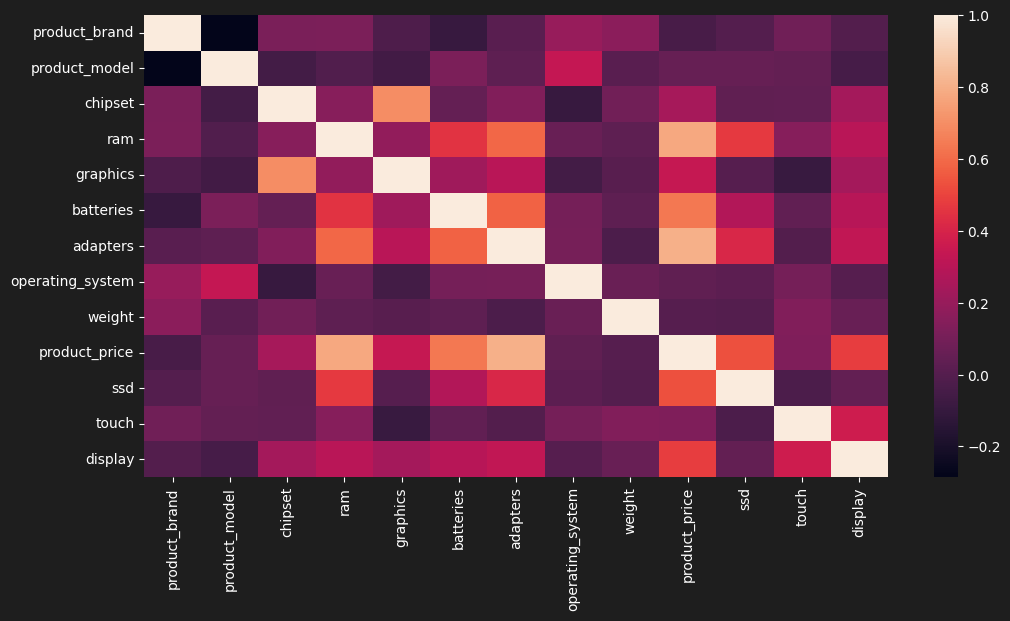

In [49]:
plt.figure(figsize=(12,6))
sns.heatmap(kndf.corr())

## model bulding with sklearn

In [71]:
# split the df into feature and target column
x = kndf.drop('product_price', axis= 1)
y = kndf['product_price']

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state= 42)

In [72]:
# import some library for measuring score and tuning
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

## Linear Regression (LR)

In [73]:
from sklearn.linear_model import LinearRegression

# create a linear regression model
lr = LinearRegression()

# fit the model 
model = lr.fit(x_train, y_train)

# make predictions
y_pred_lr = model.predict(x_test)

# calculate r-squared score
r2_lr = r2_score(y_test, y_pred_lr)
print('R-squared score:', r2_lr)

# calculate mean absolute error
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print('Mean Absolute Error:', mae_lr)

R-squared score: 0.892157328121949
Mean Absolute Error: 18726.203156905307


## Support Vector Regression (SVR) 

In [37]:
from sklearn.svm import SVR

# define the parameter grid for grid search cv
param_grid = {
    'C': [0.1, 1],                                 
    'kernel': ['linear', 'rbf'],   
    'gamma': ['auto']             
}

# create svr model
svr = SVR()

# Create GridSearchCV
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='r2')

# fit the grid search cv to find the best parameters
grid_search.fit(x_train, y_train)

# get the best parameters
best_params_svr = grid_search.best_params_

# print the best parameter
print(best_params_svr)




{'C': 1, 'gamma': 'auto', 'kernel': 'linear'}


In [38]:
# create svr with the best parameters
best_svr = SVR(**best_params_svr)

# fit the model with the best parameters
best_svr.fit(x_train, y_train)

# make predictions
y_pred_svr = best_svr.predict(x_test)

# calculate r-squared score
r2_svr = r2_score(y_test, y_pred_svr)
print('R-squared score:', r2_svr)

# calculate mean absolute error
mae_svr = mean_absolute_error(y_test, y_pred_svr)
print('Mean Absolute Error:', mae_svr)

R-squared score: 0.7714827533797926
Mean Absolute Error: 25070.44159801626


## Decision Tree Regressor (DT)

In [50]:
from sklearn.tree import DecisionTreeRegressor

# define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# create decision tree regressor
dtree = DecisionTreeRegressor()

# create grid search cv
grid_search = GridSearchCV(estimator=dtree, param_grid=param_grid, cv=5, scoring='r2')

# fit the grid search cv to find the best parameters
grid_search.fit(x_train, y_train)

# get the best parameters
best_params_dtree = grid_search.best_params_

# print the best parameter
print(best_params_dtree)


{'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 5}


In [51]:
# define the best parameter collecting from hyperparameter tuning
param_dt = {
    'max_features': None,        # Number of trees in the forest
    'max_depth': None,           # Maximum depth of the trees
    'min_samples_split': 4,      # Minimum number of samples required to split an internal node
    'min_samples_leaf': 5        # Minimum number of samples required to be at a leaf node
}
# create random forest regressor with the best parameters
best_dt = DecisionTreeRegressor(**param_dt, random_state= 42)

# fit the model with the best parameters
best_dt.fit(x_train, y_train)

# make predictions
y_pred_dt = best_dt.predict(x_test)

# calculate r-squared score
r2_dt = r2_score(y_test, y_pred_dt)
print('R-squared score:', r2_dt)

# calculate mean absolute error
mae_dt = mean_absolute_error(y_test, y_pred_dt)
print('Mean Absolute Error:', mae_dt)

R-squared score: 0.8072750242657111
Mean Absolute Error: 19299.09798305287


## Random Forest Regression (RF)

In [52]:
from sklearn.ensemble import RandomForestRegressor

# define the parameter grid for grid search cv
param_grid = {
    'n_estimators': [250, 350, 450],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],   # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required to be at a leaf node
}

# create random forest regressor
rf = RandomForestRegressor()

# create grid search cv
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', verbose= True)

# fit the grid search cv to find the best parameters
grid_search.fit(x_train, y_train)

# get the best parameters
best_params_rf = grid_search.best_params_

# print the best parameter
print(best_params_rf)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 250}


In [53]:
# define the best parameter collecting from hyperparameter tuning
param_rf = {
    'n_estimators': 450,         # Number of trees in the forest
    'max_depth': 20,             # Maximum depth of the trees
    'min_samples_split': 2,      # Minimum number of samples required to split an internal node
    'min_samples_leaf': 2        # Minimum number of samples required to be at a leaf node
}
# create random forest regressor with the best parameters
best_rf = RandomForestRegressor(**param_rf, random_state= 42)

# fit the model with the best parameters
best_rf.fit(x_train, y_train)

# make predictions
y_pred_rf = best_rf.predict(x_test)

# calculate r-squared score
r2_rf = r2_score(y_test, y_pred_rf)
print('R-squared score:', r2_rf)

# calculate mean absolute error
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print('Mean Absolute Error:', mae_rf)


R-squared score: 0.8843590228984908
Mean Absolute Error: 14081.913494206015


## Gradient Boosting Regression (GBR)

In [54]:
from sklearn.ensemble import GradientBoostingRegressor

# create a gradient boosting regressor model
gbr = GradientBoostingRegressor()

# define hyperparameters to tune
parameters = {
    'n_estimators': [150, 250, 450],
    'learning_rate': [0.01, 0.1, .15],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.5, 0.75, 1.0],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# create grid search cv object
grid_search = GridSearchCV(estimator=gbr, param_grid=parameters, scoring='r2', cv=5, verbose= True)

# fit the grid search to the data
grid_search.fit(x_train, y_train)

# get the best model
best_param_gbr = grid_search.best_params_

# print best parameter 
print(best_param_gbr)


Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
{'learning_rate': 0.15, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150, 'subsample': 1.0}


In [55]:
# define the best parameter collecting from hyperparameter tuning
param_gbr= {
    'n_estimators': 450,
    'learning_rate': 0.15,
    'max_depth': 7,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'subsample': 0.5,
    'max_features': 'log2'
}

# create gradient boosting regressor with the best parameters
best_gbr = GradientBoostingRegressor(**param_gbr, random_state=42)

# fit the model with the training data
best_gbr.fit(x_train, y_train)

# use the best model for prediction
y_pred_gbr = best_gbr.predict(x_test)

# calculate r-squared score
r2_gbr = r2_score(y_test, y_pred_gbr)
print('R-squared score:', r2_gbr)

# calculate mean absolute error
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
print('Mean Absolute Error:', mae_gbr)


R-squared score: 0.9442528116419973
Mean Absolute Error: 11260.293622878138


## Xgboost Regression (XGB)

In [40]:
import xgboost as xgb

# define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [250, 350, 450],                # number of boosting rounds
    'max_depth': [3, 6, 9],                         # maximum depth of a tree
    'learning_rate': [0.05, 0.1, 1.15, 0.2],        # learning rate
    'subsample': [0.6, 0.8, 1.0],                   # subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.8, 1.0]             # subsample ratio of columns when constructing each tree
}

# create XGBRegressor
xg_reg = xgb.XGBRegressor()

# create GridSearchCV
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, scoring='r2', verbose= True)

# fit the GridSearchCV to find the best parameters
grid_search.fit(x_train, y_train)

# get the best parameters
best_params_xgb = grid_search.best_params_

print(best_params_xgb)




Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 250, 'subsample': 0.6}


In [74]:
# define the best parameter collecting from hyperparameter tuning
param_xgb = {
    'n_estimators': 500,                # Number of boosting rounds
    'max_depth': 6,                     # Maximum depth of a tree
    'learning_rate': 0.25,              # Learning rate
    'subsample': 0.50,                   # Subsample ratio of the training instances
    'colsample_bytree': 0.5,            # Subsample ratio of columns when constructing each tree
}

# create XGBRegressor with the best parameters
best_xg_reg = xgb.XGBRegressor(**param_xgb)

# fit the model with the best parameters
model_xgb = best_xg_reg.fit(x_train, y_train)

# make predictions
y_pred_xgb = best_xg_reg.predict(x_test)

# calculate r-squared score
r2_xgb = r2_score(y_test, y_pred_xgb)
print('R-squared score:', r2_xgb)

# calculate mean absolute error
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print('Mean Absolute Error:', mae_xgb)

R-squared score: 0.9468344806501346
Mean Absolute Error: 11473.162285596805


In [58]:
# creat a df to store the  r2 score and mae value
algorithm = ['LR', 'SVR','DTR','RFR', 'GBR','XGB']
r2scores = [r2_lr, r2_svr, r2_dt, r2_rf, r2_gbr, r2_xgb]
mae = [mae_lr, mae_svr, mae_dt, mae_rf, mae_gbr, mae_xgb]

score = {'algorithm': algorithm, 'r2scores': r2scores,'mae': mae}
df_score = pd.DataFrame(score)
print(df_score)

  algorithm  r2scores           mae
0        LR  0.892157  18726.203157
1       SVR  0.789367  24516.108969
2       DTR  0.807275  19299.097983
3       RFR  0.884359  14081.913494
4       GBR  0.944253  11260.293623
5       XGB  0.946834  11473.162286


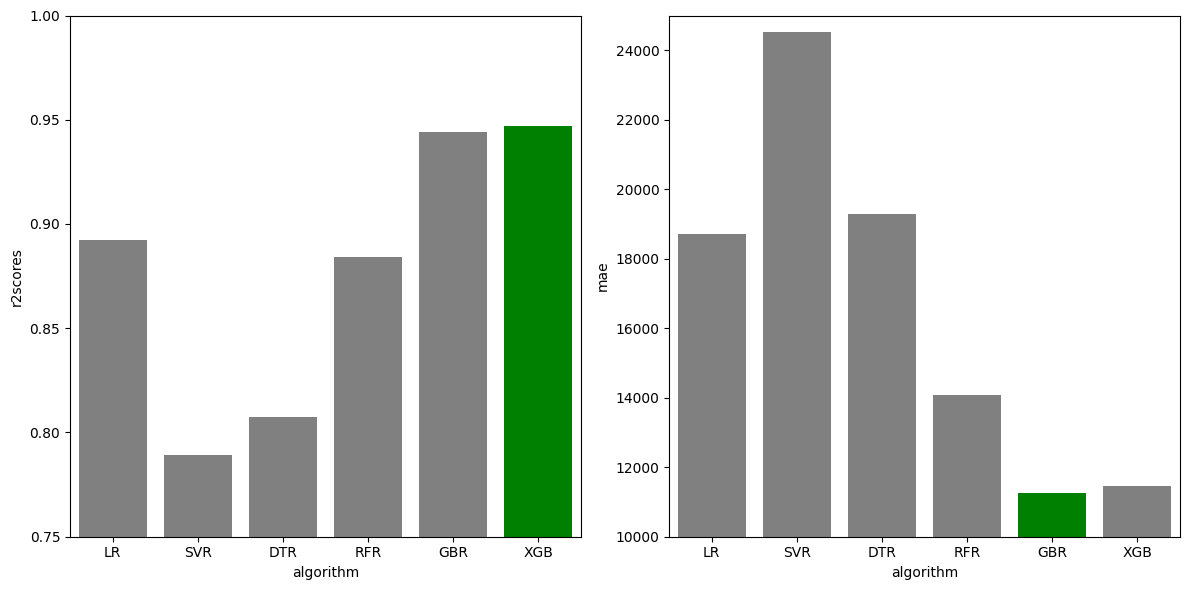

In [59]:
# difine row and column through subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# first subplot
sns.barplot(data=df_score, x='algorithm', y='r2scores', ax=axes[0],color= '#54A4AF')
axes[0].set_ylim(0.75, 1)  # set y-axis limits for the first subplot

# second subplot
sns.barplot(data=df_score, x='algorithm', y='mae', ax=axes[1], color= '#54A4AF')
axes[1].set_ylim(10000, 25000)  # set y-axis limits for the second subplot

# Compare R2 scores and MAE values to set bar colors
r2_max = df_score['r2scores'].max()
mae_min = df_score['mae'].min()

# Set bar colors based on R2 scores
for i, bar in enumerate(axes[0].patches):
    if df_score.loc[i, 'r2scores'] == r2_max:
        bar.set_facecolor('green')  # Color the bar blue if it has the highest R2 score
    else:
        bar.set_facecolor('gray')  # Color other bars gray

# Set bar colors based on MAE values
for i, bar in enumerate(axes[1].patches):
    if df_score.loc[i, 'mae'] == mae_min:
        bar.set_facecolor('green')  # Color the bar green if it has the lowest MAE value
    else:
        bar.set_facecolor('gray')  # Color other bars gray


plt.tight_layout()  # adjust layout to prevent overlapping
plt.show()


## Export file 

In [76]:
# import some librrary for exporting df
from sklearn.preprocessing import  OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pickle

In [77]:
# Define the columns to encode
col_list = ['product_brand', 'product_model', 'chipset', 'graphics', 'operating_system', 'touch', 'display']

# Create a pipeline
pipeline = Pipeline([
    ('encoder', ColumnTransformer(transformers=[
        ('ordinal_encoder', OneHotEncoder(sparse=False, drop= 'first'), col_list)
    ], remainder='passthrough')),  # Encoding for multiple columns
    ('imputer', KNNImputer(n_neighbors=5)),  # Imputation
    ('xgb', xgb.XGBRegressor(n_estimators=500, max_depth=5, learning_rate=0.025, subsample=0.50, colsample_bytree=0.50))  # XGBoost model with best parameters
])

# Fit the pipeline
pipeline.fit(x_train, y_train)

# Make predictions
y_pred_xgb = pipeline.predict(x_test)

# Calculate evaluation metrics
r2_xgb = r2_score(y_test, y_pred_xgb)
print('R-squared score:', r2_xgb)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print('Mean Absolute Error:', mae_xgb)

R-squared score: 0.9375028683253629
Mean Absolute Error: 11459.917675046992


In [75]:
# pickle.dump(kndf, open('kndf.sav', 'wb'))
# pickle.dump(model, open('lr.sav' ,'wb'))